In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
os.chdir("drive/My Drive/Google_Colab_Drive/Siamese_Network_and_Triplet_Loss")

# Create a Siamese Network with Triplet Loss in Keras

# Task 1: Understanding the Approach

In [3]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


In [4]:
!ls

assets	pca_plotter.py	__pycache__  SiameseNetwork_wTripletLoss.ipynb


## Understanding the Approach

In this notebook I will create a Siamese Network, implement a Triplet Loss function and train the network with custom Triplet Loss function on MNIST dataset. 

In the process of training, the Siamese Network will learn to produce feature embeddings of different classes from the dataset in a way so that embeddings from different classes will start moving away from each other in the embedding vector space. 

This is idea used in Face Verification systems. A model is trained to produce embeddings for faces in way that embeddings of 2 images of same person are going to be a lot closer in the embedding vector space compare to embedding vectors of 2 images of 2 different persons. 

**Image Classification** doesn't scale for this type of problem(Face Verification). 

The general approach is as follows, 
All the images goes through a CNN Network(It can be anything, CNN is theoretically robust to work on images and practically just works better on Images) and get a vector representation of each at the end which we call an embedding. 
f(image_x) => Embedding_x

The model should learn parameters in a way, so that if it sees a photo of the same person(positive example) as a reference photo (anchor image) then the embedding of those 2 photos(anchor and positive example) need to be close in embedding vector space. If it is a image of different person (negative example) then the embeddings of 2 photos (anchor and negative example) should be far apart. 

This appraoch is taken from the popular [FaceNet](https://arxiv.org/abs/1503.03832) paper.

We have a CNN model called `EmbeddingModel`:

![CNN](./assets/CNN.png)

We use three images for each training example:
1. `person1_image1.jpg` (Anchor Example, represented below in green)
2. `person1_image2.jpg` (Positive Example, in blue)
3. `person2_image1.jpg` (Negative Example, in red).

![Embeddings](./assets/embeddings.png)


## Siamese Network

All the three images of an example pass through the model, and we get the three Embeddings: One for the Anchor Example, one for the Positive Example, and one for the Negative Example.

![Siamese Network](./assets/siamese.png)

The three instances of the `EmbeddingModel` shown above are not different instances. It's the same, shared model instance - i.e. the parameters are shared, and are updated for all the three paths simultaneously.

# Task 2: Importing the Data

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


**Unrolling the Xs and (0-1) Normalization**

In [7]:
x_train = np.reshape(np.ravel(x_train), (x_train.shape[0], -1))
print(x_train.shape)
x_test = np.reshape(np.ravel(x_test), (x_test.shape[0], -1))
print(x_test.shape)

(60000, 784)
(10000, 784)


In [8]:
x_train = x_train/255.
x_test = x_test/255.

# Task 3: Plotting Examples

In [9]:
%matplotlib inline

In [10]:
def plot_triplet(triplet):
  '''
  triplet ==> List of 3 images (Anchor, Positive, Negative)
  '''
  plt.figure(figsize=(6, 2))
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.reshape(triplet[i], (28, 28)), cmap = 'binary')
    plt.xticks([])
    plt.yticks([])
  plt.show()


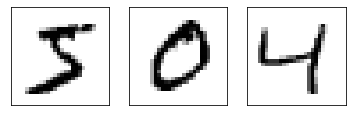

In [11]:
plot_triplet([x_train[0], x_train[1], x_train[2]])

# Task 4: A Batch of Triplets

In [12]:
def create_batch(batch_size):
  '''
  batch_size ==> int, size of the batches you want to create
  returns a list of [Anchors, Positives, Negatives]
  Anchors   => Numpy Array of flatten images
  Positives => Numpy Array of flatten images
  Negatives => Numpy Array of flatten images
  '''
  anchors = np.zeros((batch_size, 784), dtype=np.float32)
  positives = np.zeros((batch_size, 784), dtype=np.float32)
  negatives = np.zeros((batch_size, 784), dtype=np.float32)

  for i in range(batch_size):
    index = random.randint(0, 60000-1)
    anc = x_train[index]
    y = y_train[index]

    indicies_for_pos = np.squeeze(np.where(y_train==y))
    indicies_for_neg = np.squeeze(np.where(y_train!=y))
    
    pos = x_train[indicies_for_pos[random.randint(0, len(indicies_for_pos)-1)]]
    neg = x_train[indicies_for_neg[random.randint(0, len(indicies_for_neg)-1)]]

    anchors[i] = anc
    positives[i] = pos
    negatives[i] = neg

  return [anchors, positives, negatives]




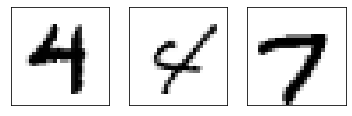

In [13]:
test_triplets = create_batch(1)
plot_triplet(test_triplets)

# Task 5: Embedding Model

**The model will take images as input and will return embeddings of the images as output**

In [14]:
emb_dim = 64
embedding_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape = (784, )),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


**Sample output from the model**

In [15]:
example = x_train[0]
example_emb = embedding_model.predict(np.expand_dims(example, axis = 0))[0]
print(example_emb)

[0.3999828  0.446646   0.45748895 0.526802   0.5986202  0.49448985
 0.38178533 0.50752807 0.5364211  0.46162093 0.5350903  0.5745711
 0.63686895 0.45205957 0.44741702 0.5351436  0.6101066  0.47040814
 0.39065322 0.42490235 0.48322117 0.46493113 0.40219352 0.4675437
 0.5683624  0.55844015 0.41356552 0.37000436 0.5918817  0.47014165
 0.35841483 0.40749097 0.5592337  0.4650771  0.4935932  0.53710324
 0.52066123 0.4441576  0.4481573  0.39109197 0.5194362  0.599539
 0.61154544 0.5460963  0.39432895 0.41255188 0.5913576  0.5333147
 0.4197106  0.48653957 0.61542994 0.44173682 0.55473715 0.40779015
 0.4250753  0.59425193 0.65408903 0.4939644  0.4277034  0.5527666
 0.6037471  0.49984705 0.37092125 0.6224467 ]


# Task 6: Siamese Network
**Concatenation of the embeddings [anchor, positive, negative] by column.**

In [16]:
in_anc = tf.keras.layers.Input(shape=(784, ))
in_pos = tf.keras.layers.Input(shape=(784, ))
in_neg = tf.keras.layers.Input(shape=(784, ))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1) # Column wise concatenation.

siamese_net = tf.keras.models.Model(
    inputs  = [in_anc, in_pos, in_neg],
    outputs = out
)

siamese_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 64)           54400       input_1[0][0]                    
                                                                 input_2[0][0]         

# Task 7: Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [21]:
def triplet_loss(alpha= 0.2, emb_dim=64):
  # This encapsulation gives an opportunity  to pass alpha, emb_dim at run time.
  def loss(y_true, y_pred): # Even though there is no ground truth here, for a custom loss function this is the signature we have to follow
    anc, pos, neg  = y_pred[:, : emb_dim], y_pred[:, emb_dim : 2*emb_dim], y_pred[:, 2*emb_dim : 3*emb_dim]
    dp = tf.reduce_mean(tf.square(anc - pos), axis = 1) # reduce_mean is column wise operation
    dn = tf.reduce_mean(tf.square(anc - neg), axis = 1) # reduce_mean is column wise operation
    loss_value = tf.maximum(dp - dn + alpha, 0.)
    return loss_value
  return loss # Returning the function

# Task 8: Data Generator

In [22]:
def data_generator(batch_size, emb_dim):
  while True:
    x = create_batch(batch_size = batch_size)
    y = np.zeros((batch_size, 3*emb_dim)) # We need it for the loss function and model.fit()
    yield x, y

# Task 9: Model Training

In [23]:
alpha = 0.2  # Same value as FaceNet paper
batch_size = 1024
epochs = 10
steps_per_epoch = int(60000/batch_size)
siamese_net.compile(loss=triplet_loss(alpha=alpha, emb_dim=emb_dim), optimizer='adam')

X, Y = x_test[:1000], y_test[:1000]

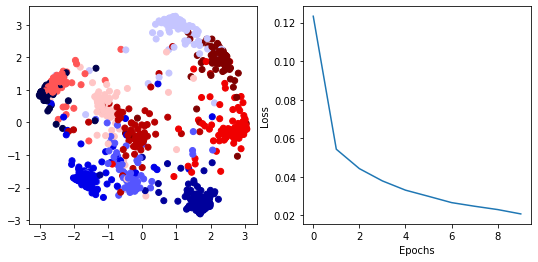

In [24]:
hist = siamese_net.fit(
    data_generator(batch_size, emb_dim), 
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    verbose = False,
    callbacks = [PCAPlotter(plt, embedding_model, X, Y)]
)

**We can see that the different digits(differentiated by colors have from separte clusters which are relatively far away from their respective own kind**